# Data retrieval

First we will create a dataset of random arxiv articles in random categories. Our goal in this notebook will be to compare machine learning models built to predict the main category label and cross-post labels.

In [53]:
%reload_ext autoreload
%autoreload 2

In [54]:
from utilities import (
    get_articles_random_categories,
    scrape_categories,
    clean_string,
    get_arxiv_categories,
    get_article_by_id,
    build_arxiv_dict,
    build_arxiv_df,
)
import pandas as pd
import numpy as np
import re
import time

## Creating data

In [56]:
arXiv_categories = get_arxiv_categories()

In [62]:
# This part of the code is the part which generates the dataset. We will only run it once to create a new dataset
NARTICLES = 2000
# NARTICLES = 100
list_articles = []


while len(list_articles) < NARTICLES:
    ret = get_articles_random_categories()
    if ret is None:
        continue
    for article in ret[1]:
        list_articles.append(build_arxiv_dict(article))
    time.sleep(1)

In [63]:
random_articles_df = build_arxiv_df(list_articles, arXiv_categories)
random_articles_df.to_csv("data/arxiv_random.csv")

# Naive Bayes analysis

In this analysis, we will start by building a model to predict the primary category from the ensemble of categories. We will first guess the general primary category instead of the exact subcategory. Let us start with an example: if we consider [this paper](https://arxiv.org/abs/2402.13154), we see it belongs to `cond-mat.str-el`, `cond-mat.stat-mech`, `hep-th` and `quant-ph`, the first one being the primary category. We want to predict from this list of sub-categories that first, this paper is primarily a `cond-mat` paper.

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ValidationCurveDisplay, LearningCurveDisplay
from sklearn.utils import shuffle

import seaborn as sns

In [65]:
# loading data
data_df = pd.read_csv("data/arxiv_random.csv")

In [66]:
def get_primary_parent(cat):
    if "." in cat:
        return cat.split(".")[0]
    else:
        return cat

In [67]:
features = [x for x in list(data_df.columns) if x.startswith("is_")]
print(features)
print(len(features))
target = "primary_category"

X = data_df[features]
y = data_df[target].apply(get_primary_parent)

['is_q-fin.RM', 'is_math.SP', 'is_math.CV', 'is_nucl-ex', 'is_physics.gen-ph', 'is_math.AC', 'is_q-fin', 'is_math.SG', 'is_cs.MA', 'is_astro-ph', 'is_math.LO', 'is_stat.ML', 'is_q-fin.PR', 'is_math.GT', 'is_physics.acc-ph', 'is_stat.ME', 'is_cs.CV', 'is_math.NA', 'is_cs.GR', 'is_cond-mat.quant-gas', 'is_q-bio.QM', 'is_cs.IR', 'is_math.RT', 'is_cs.SI', 'is_cs.SC', 'is_nlin.CD', 'is_math.AP', 'is_cs.PL', 'is_q-bio.OT', 'is_eess.SP', 'is_q-fin.MF', 'is_physics.space-ph', 'is_cond-mat.stat-mech', 'is_math.GR', 'is_nlin.PS', 'is_physics.ins-det', 'is_cs.NA', 'is_nucl-th', 'is_math.GM', 'is_stat.CO', 'is_cs.DM', 'is_astro-ph.IM', 'is_physics.plasm-ph', 'is_cs.SE', 'is_q-fin.ST', 'is_astro-ph.EP', 'is_physics.soc-ph', 'is_hep-ph', 'is_eess', 'is_stat.OT', 'is_cs.AI', 'is_math.QA', 'is_cs.ET', 'is_math.FA', 'is_physics.hist-ph', 'is_econ', 'is_econ.TH', 'is_physics.ed-ph', 'is_cs.DL', 'is_cs.CG', 'is_q-bio.BM', 'is_econ.EM', 'is_math.DG', 'is_econ.GN', 'is_math.OC', 'is_astro-ph.HE', 'is_q-bio

We start with a Gaussian Naive Bayes model. We will compare it directly to the Multinomial Bayes model.

In [79]:
gaussian_model = GaussianNB()
scores = cross_val_score(gaussian_model, X, y, cv=5)
scores.mean()

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.905

<Axes: >

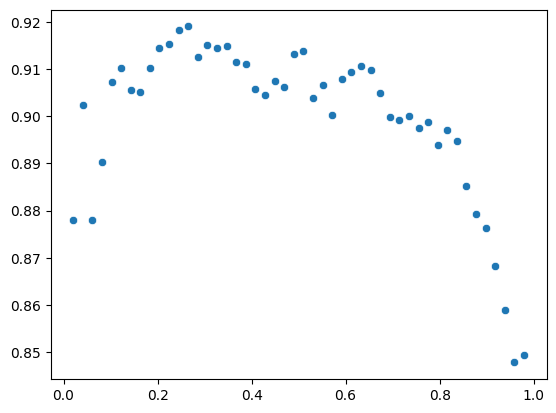

In [69]:
def get_score_GB(training_proportion):
    model = GaussianNB()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=training_proportion, random_state=0
    )
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return (y_predicted == y_test).sum() / y_test.size


get_score_array_GB = np.vectorize(get_score_GB)

proportions = np.linspace(0, 1, 50)[1:-1]
scores_GB = get_score_array_GB(proportions)

sns.scatterplot(x=proportions, y=scores_GB)

In [80]:
mb_model = MultinomialNB()
scores = cross_val_score(mb_model, X, y, cv=5)
scores.mean()

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.8734999999999999

<Axes: >

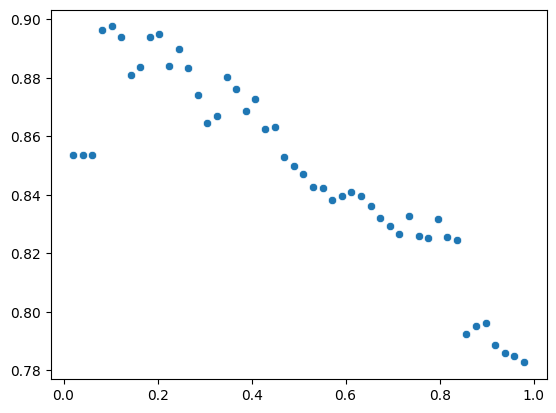

In [81]:
def get_score_MB(training_proportion):
    model = MultinomialNB()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=training_proportion, random_state=0
    )
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return (y_predicted == y_test).sum() / y_test.size


get_score_MB_array = np.vectorize(get_score_MB)

proportions = np.linspace(0, 1, 50)[1:-1]
scores_MB = get_score_MB_array(proportions)

sns.scatterplot(x=proportions, y=scores_MB)

We see that both the Gaussian and Multinomial Bayes models are quite good and both show a worsening of predictions at large sample size. This can be understood by the fact that Bayes models are better when the dimensionality is very large compared to the sample size.

# Other classifiers

## Logistic regression

In [86]:
from sklearn.linear_model import LogisticRegression

In [87]:
lr_model = LogisticRegression(random_state=0)
scores = cross_val_score(lr_model, X, y, cv=5)
scores.mean()

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.9339999999999999

<Axes: >

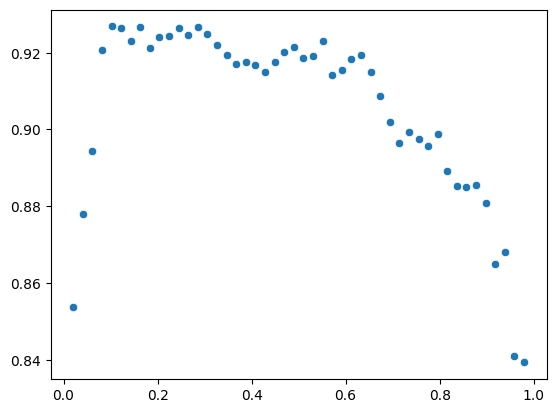

In [88]:
def get_score_LR(training_proportion):
    model = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=training_proportion, random_state=0
    )
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return (y_predicted == y_test).sum() / y_test.size


get_score_LR_array = np.vectorize(get_score_LR)

proportions = np.linspace(0, 1, 50)[1:-1]
scores_LR = get_score_LR_array(proportions)

sns.scatterplot(x=proportions, y=scores_LR)

## Random Forest Regressor

In [90]:
from sklearn.ensemble import RandomForestClassifier

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


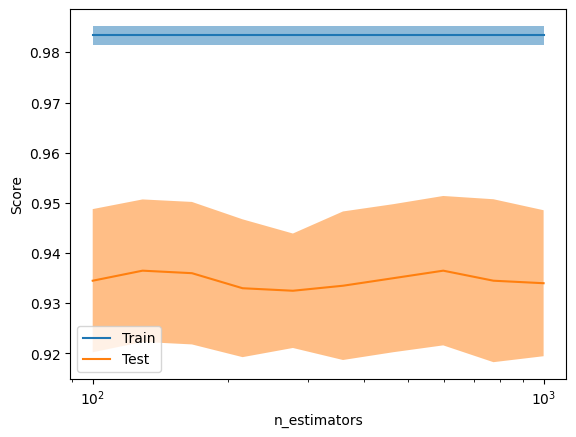

In [99]:
Xshuffle, yshuffle = X, y

ValidationCurveDisplay.from_estimator(
    RandomForestClassifier(),
    Xshuffle,
    yshuffle,
    param_name="n_estimators",
    param_range=np.logspace(2, 3, 10).astype(np.int64),
)

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


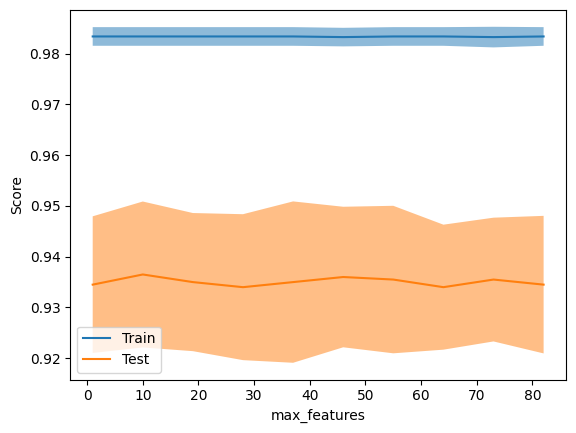

In [101]:
Xshuffle, yshuffle = X, y

ValidationCurveDisplay.from_estimator(
    RandomForestClassifier(),
    Xshuffle,
    yshuffle,
    param_name="max_features",
    param_range=np.linspace(1, len(features) // 2, 10).astype(np.int64),
)

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


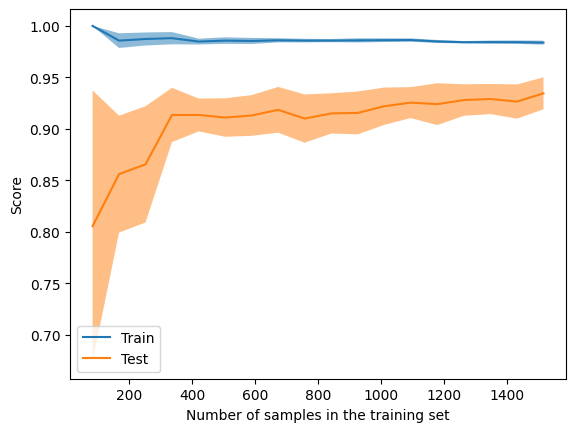

In [110]:
LearningCurveDisplay.from_estimator(
    RandomForestClassifier(),
    Xshuffle,
    yshuffle,
    train_sizes=np.linspace(0, 0.8 * y.size, 20).astype(np.int64)[1:-1],
    cv=5,
)

## KNeighbors

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
KNN_model = KNeighborsClassifier()
scores = cross_val_score(KNN_model, X, y, cv=5)
scores.mean()

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.9075

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


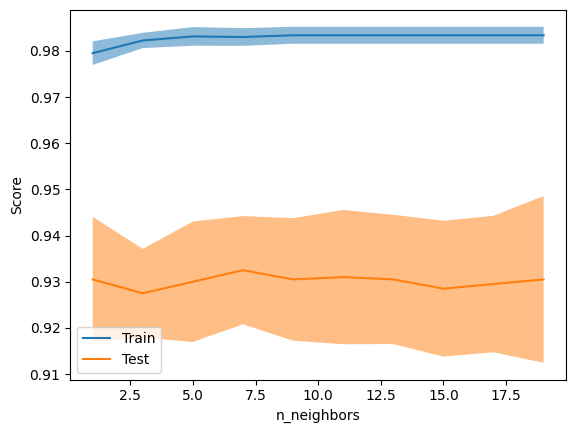

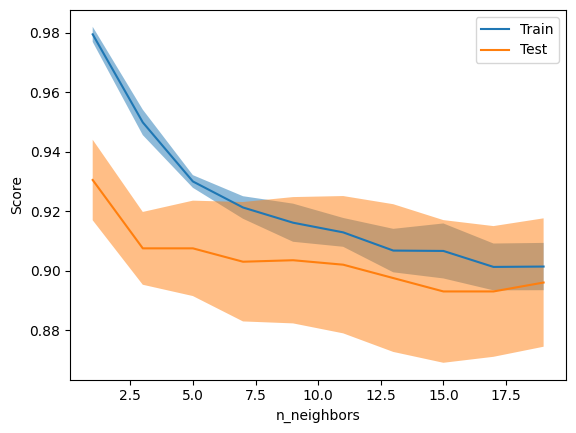

In [119]:
Xshuffle, yshuffle = X, y

ValidationCurveDisplay.from_estimator(
    KNeighborsClassifier(weights="distance"),
    Xshuffle,
    yshuffle,
    param_name="n_neighbors",
    param_range=np.arange(1, 21, 2).astype(np.int64),
)

ValidationCurveDisplay.from_estimator(
    KNeighborsClassifier(weights="uniform"),
    Xshuffle,
    yshuffle,
    param_name="n_neighbors",
    param_range=np.arange(1, 21, 2).astype(np.int64),
)

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


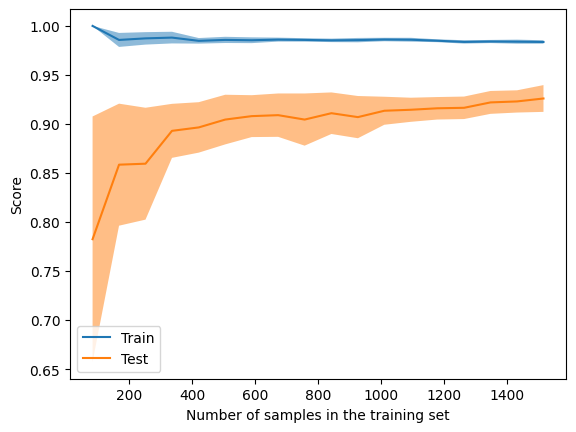

In [122]:
LearningCurveDisplay.from_estimator(
    KNeighborsClassifier(weights="distance"),
    Xshuffle,
    yshuffle,
    train_sizes=np.linspace(0, 0.8 * y.size, 20).astype(np.int64)[1:-1],
    cv=5,
)

## SVC

In [124]:
from sklearn.svm import SVC

/home/nchagnet/pyenvs/zoteroML_py/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


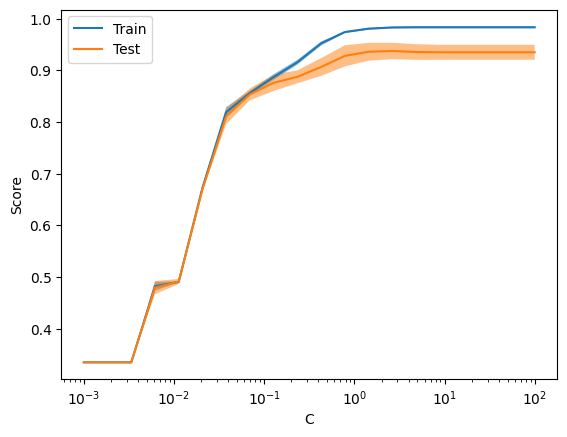

In [127]:
Xshuffle, yshuffle = X, y

ValidationCurveDisplay.from_estimator(
    SVC(),
    Xshuffle,
    yshuffle,
    param_name="C",
    param_range=np.logspace(2, -3, 20),
)